# Objective I: Automated Parallel Corpus Generation

This notebook will create a parallel corpus for scientific translation by:

1. Collecting article metadata from the [OpenAlex](https://openalex.org/) Database
2. Automatically download the raw PDFs
3. Convert PDFs to markdown (preserving layout)
4. Filter by language


### Configuration


In [50]:
LANGUAGES = {
    "ta": {"name": "Tamil", "max_articles": 400, "target_sentences": 1000},
    "bn": {"name": "Bengali", "max_articles": 400, "target_sentences": 1000},
    "th": {"name": "Thai", "max_articles": 400, "target_sentences": 1000},
    "sw": {"name": "Swahili", "max_articles": 400, "target_sentences": 1000},
    "et": {"name": "Estonian", "max_articles": 400, "target_sentences": 1000},
}

### Imports and Setup


In [51]:
import os
import time
import pymupdf
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import pymupdf4llm
from lingua import LanguageDetectorBuilder

import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from requests.adapters import HTTPAdapter, Retry

import re
import json
import spacy

In [ ]:
DATA_DIR = Path.cwd() / "data"
METADATA_DIR = DATA_DIR / "metadata"
PDFS_DIR = DATA_DIR / "pdfs"
EXTRACTED_DIR = DATA_DIR / "extracted"
SENTENCES_DIR = DATA_DIR / "sentences"
RESULTS_DIR = Path.cwd() / "results"

for dir_path in [
    DATA_DIR,
    METADATA_DIR,
    PDFS_DIR,
    EXTRACTED_DIR,
    RESULTS_DIR,
    SENTENCES_DIR,
]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("Directories created")
print(f"Data directory: {DATA_DIR}")

Directories created
Data directory: c:\Users\lucas\OneDrive\Desktop\projects\2025-11-17_Averroes-AI\data


In [53]:
APPROX_SENTENCES_PER_ARTICLE = 150

### Helper Functions


In [54]:
def reconstruct_abstract(inverted_index):
    if not inverted_index:
        return ""

    word_indeces = []
    for word, indeces in inverted_index.items():
        word_indeces.extend([(idx, word) for idx in indeces])

    sorted_indeces = sorted(word_indeces, key=lambda x: x[0])
    return " ".join([index[1] for index in sorted_indeces])


def download_metadata(lang_code: str, max_articles: int, output_dir: Path):
    """Download article metadata from OpenAlex"""
    url = "https://api.openalex.org/works"
    params = {
        "filter": f"language:{lang_code},type:article",
        "select": "abstract_inverted_index,primary_location,title,doi,publication_date",
        "mailto": "example@email.com",
        "page": 1,
    }

    session = requests.Session()
    article_data = []
    total_articles = 0

    with tqdm(total=max_articles, desc=f"Collecting {lang_code} articles") as pbar:
        while total_articles < max_articles:
            response = session.get(url, params=params)

            try:
                results = response.json()["results"]

                for result in results:
                    primary_location = result["primary_location"]
                    pdf_url = primary_location.get("pdf_url", "")

                    if not pdf_url:
                        continue

                    abstract = reconstruct_abstract(result["abstract_inverted_index"])

                    article_data.append(
                        {
                            "title": result["title"],
                            "abstract": abstract,
                            "pdf_url": pdf_url,
                            "doi": result["doi"],
                            "publication_date": result["publication_date"],
                        }
                    )

                    pbar.update(1)
                    total_articles += 1
                    if total_articles >= max_articles:
                        break
            except Exception as e:
                print(f"Error downloading article info: {str(e)}")

            params["page"] += 1
            time.sleep(4)
    df = pd.DataFrame(article_data)
    metadata_path = output_dir / f"{lang_code}_article_data.csv"
    df.to_csv(metadata_path, index=False, encoding="utf-8")
    return df


def setup_pdf_driver(download_dir: Path):
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument(
        "--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
    )
    options.add_experimental_option(
        "prefs",
        {
            "download.default_directory": str(download_dir.absolute()),
            "download.prompt_for_download": False,
            "download.directory_upgrade": True,
            "plugins.always_open_pdf_externally": True,
            "plugins.plugins_disabled": ["Chrome PDF Viewer"],
        },
    )
    return webdriver.Chrome(options=options)


def download_pdf(driver, pdf_url: str):
    driver.get(pdf_url)
    WebDriverWait(driver, 10).until(
        lambda d: d.execute_script("return document.readyState") == "complete"
    )
    time.sleep(5)


def detect_language(text: str, detector):
    result = detector.detect_language_of(text)
    return result.iso_code_639_1.name.lower() if result else None

In [55]:
def clean_sentence(sentence: str):
    sentence = re.sub(r"\s+", " ", sentence)
    sentence = re.sub(r"#+\s*", "", sentence)
    sentence = re.sub(r"\*+", "", sentence)
    sentence = re.sub(r"\[|\]|\(|\)", "", sentence)
    return sentence.strip()


def is_valid_sentence(sentence: str, min_length: int = 10, max_length: int = 500):
    if len(sentence) < min_length:
        return False
    if len(sentence) > max_length:
        return False
    if not re.search(r"[a-zA-Z\u0080-\uFFFF]", sentence):
        return False
    if len(re.findall(r"[a-zA-Z\u0080-\uFFFF]", sentence)) < 5:
        return False
    return True


def extract_sentence_from_markdown(md_path: Path, lang_code: str, nlp):
    text = md_path.read_text(encoding="utf-8")

    # Cleaning
    text = re.sub(r"```.*?```", "", text, flags=re.DOTALL)
    text = re.sub(r"\|.*?\|", "", text)
    text = re.sub(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        "",
        text,
    )

### Download Metadata


In [56]:
metadata_stats = []

for lang_code, config in LANGUAGES.items():
    df = download_metadata(lang_code, config["max_articles"], METADATA_DIR)
    metadata_stats.append(
        {
            "Language": config["name"],
            "Code": lang_code,
            "Articles": len(df),
            "With Abstracts": df["abstract"].notna().sum(),
        }
    )

display(pd.DataFrame(metadata_stats))

,Language,Code,Articles,With Abstracts
0,Tamil,ta,400,400
1,Bengali,bn,400,400
2,Thai,th,400,400
3,Swahili,sw,400,400
4,Estonian,et,400,400


### Download PDFs


In [57]:
download_stats = []

for lang_code, config in LANGUAGES.items():
    lang_pdf_dir = PDFS_DIR / lang_code
    lang_pdf_dir.mkdir(parents=True, exist_ok=True)

    # Load metadata
    metadata_path = METADATA_DIR / f"{lang_code}_article_data.csv"
    if not metadata_path.exists():
        print("No metadata found, skipping")
        continue

    articles_df = pd.read_csv(metadata_path)
    driver = setup_pdf_driver(lang_pdf_dir)

    # Download
    success_count = 0
    for idx, article in tqdm(
        articles_df.iterrows(),
        total=len(articles_df),
        desc=f"Downloading {config['name']}",
    ):
        try:
            download_pdf(driver, article["pdf_url"])
            success_count += 1
        except:
            pass

    driver.quit()

    download_stats.append(
        {
            "Language": config["name"],
            "Attempted": len(articles_df),
            "Downloaded": success_count,
        }
    )

display(pd.DataFrame(download_stats))

,Language,Attempted,Downloaded
0,Tamil,400,395
1,Bengali,400,399
2,Thai,400,400
3,Swahili,400,393
4,Estonian,400,399


### Convert to Markdown


Processing Tamil:   0%|          | 0/335 [00:00<?, ?it/s]

Processing Bengali:   0%|          | 0/294 [00:00<?, ?it/s]

Processing Thai:   0%|          | 0/317 [00:00<?, ?it/s]

Processing Swahili:   0%|          | 0/304 [00:00<?, ?it/s]

Processing Estonian:   0%|          | 0/282 [00:00<?, ?it/s]

,Language,Total PDFs,Kept,Wrong Language,Errors,Success Rate
0,Tamil,335,7,1,0,2.1%
1,Bengali,294,7,39,2,2.4%
2,Thai,317,7,1,0,2.2%
3,Swahili,304,7,0,0,2.3%
4,Estonian,282,7,24,0,2.5%


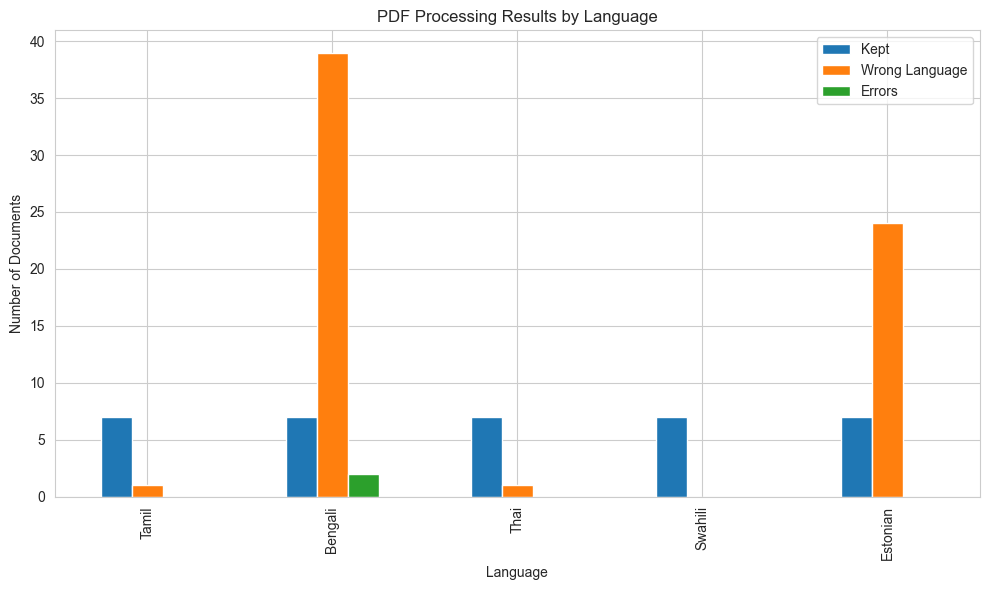

In [58]:
processing_stats = []
detector = LanguageDetectorBuilder.from_all_languages().build()

for lang_code, config in LANGUAGES.items():
    lang_pdf_dir = PDFS_DIR / lang_code
    lang_extracted_dir = EXTRACTED_DIR / lang_code
    lang_extracted_dir.mkdir(parents=True, exist_ok=True)

    if not lang_pdf_dir.exists():
        continue

    pdf_files = list(lang_pdf_dir.glob("*.pdf"))
    kept_count = 0
    wrong_lang_count = 0
    error_count = 0

    for pdf_path in tqdm(
        pdf_files, total=len(pdf_files), desc=f"Processing {config['name']}"
    ):
        try:
            with pymupdf.open(str(pdf_path)) as doc:
                md_text = pymupdf4llm.to_markdown(doc)

            detected_code = detect_language(md_text, detector)
            if detected_code == lang_code:
                new_pdf_path = lang_pdf_dir / f"{kept_count}.pdf"
                pdf_path.rename(new_pdf_path)

                md_path = lang_extracted_dir / f"{kept_count}.md"
                md_path.write_text(md_text, encoding="utf-8")
                kept_count += 1
            else:
                pdf_path.unlink()
                wrong_lang_count += 1

            if kept_count * APPROX_SENTENCES_PER_ARTICLE > config["target_sentences"]:
                break

        except Exception as e:
            pdf_path.unlink(missing_ok=True)
            error_count += 1

    processing_stats.append(
        {
            "Language": config["name"],
            "Total PDFs": len(pdf_files),
            "Kept": kept_count,
            "Wrong Language": wrong_lang_count,
            "Errors": error_count,
            "Success Rate": (
                f"{kept_count/len(pdf_files)*100:.1f}%" if pdf_files else "0%"
            ),
        }
    )

stats_df = pd.DataFrame(processing_stats)
display(stats_df)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
stats_df.plot(x="Language", y=["Kept", "Wrong Language", "Errors"], kind="bar", ax=ax)
ax.set_title("PDF Processing Results by Language")
ax.set_ylabel("Number of Documents")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "processing_results.png", dpi=150, bbox_inches="tight")
plt.show()

### Extract sentences


In [59]:
extraction_stats = []
nlp = spacy.load("xx_ent_wiki_sm")
nlp.add_pipe("sentencizer")
detector = LanguageDetectorBuilder.from_all_languages().build()

for lang_code, config in LANGUAGES.items():
    lang_sents_file = SENTENCES_DIR / f"{lang_code}_sentences.jsonl"
    lang_extracted_dir = EXTRACTED_DIR / lang_code

    if not lang_extracted_dir.exists():
        continue

    markdown_files = list(lang_extracted_dir.glob("*.md"))
    total_sentences = 0

    with open(lang_sents_file, "w", encoding="utf-8") as out_file:
        for markdown_path in tqdm(
            markdown_files,
            total=len(markdown_files),
            desc=f"Extracting {config['name']}",
        ):
            try:
                md_text = markdown_path.read_text(encoding="utf-8")

                # Clean markdown text
                md_text = re.sub(r"```.*?```", "", md_text, flags=re.DOTALL)
                md_text = re.sub(r"\|.*?\|", "", md_text)
                md_text = re.sub(
                    r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
                    "",
                    md_text,
                )

                doc = nlp(md_text)

                sentences = []
                for sent in doc.sents:
                    cleaned = clean_sentence(sent.text)
                    detected_code = detect_language(cleaned, detector)
                    if is_valid_sentence(cleaned) and detected_code == lang_code:
                        sentences.append(cleaned)

                for idx, sentence in enumerate(sentences):
                    data = {
                        "text": sentence,
                        "lang": lang_code,
                        "doc_id": markdown_path.stem,
                        "sent_id": idx,
                    }
                    out_file.write(json.dumps(data, ensure_ascii=False) + "\n")
                    total_sentences += 1

                    if total_sentences >= config["target_sentences"]:
                        break

            except Exception as e:
                print(f"Error when extracting sentences: {str(e)}")

        extraction_stats.append(
            {
                "Language": config["name"],
                "Code": lang_code,
                "Documents": len(markdown_files),
                "Sentences": total_sentences,
                "Avg per Doc": (
                    f"{total_sentences/len(markdown_files):.1f}"
                    if markdown_files
                    else "0"
                ),
            }
        )


stats_df = pd.DataFrame(extraction_stats)
display(stats_df)

Extracting Tamil:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting Bengali:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting Thai:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting Swahili:   0%|          | 0/7 [00:00<?, ?it/s]

Extracting Estonian:   0%|          | 0/7 [00:00<?, ?it/s]

,Language,Code,Documents,Sentences,Avg per Doc
0,Tamil,ta,7,559,79.9
1,Bengali,bn,7,1004,143.4
2,Thai,th,7,185,26.4
3,Swahili,sw,7,1004,143.4
4,Estonian,et,7,1004,143.4


C:\Users\lucas\AppData\Local\Temp\ipykernel_59924\2800833076.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


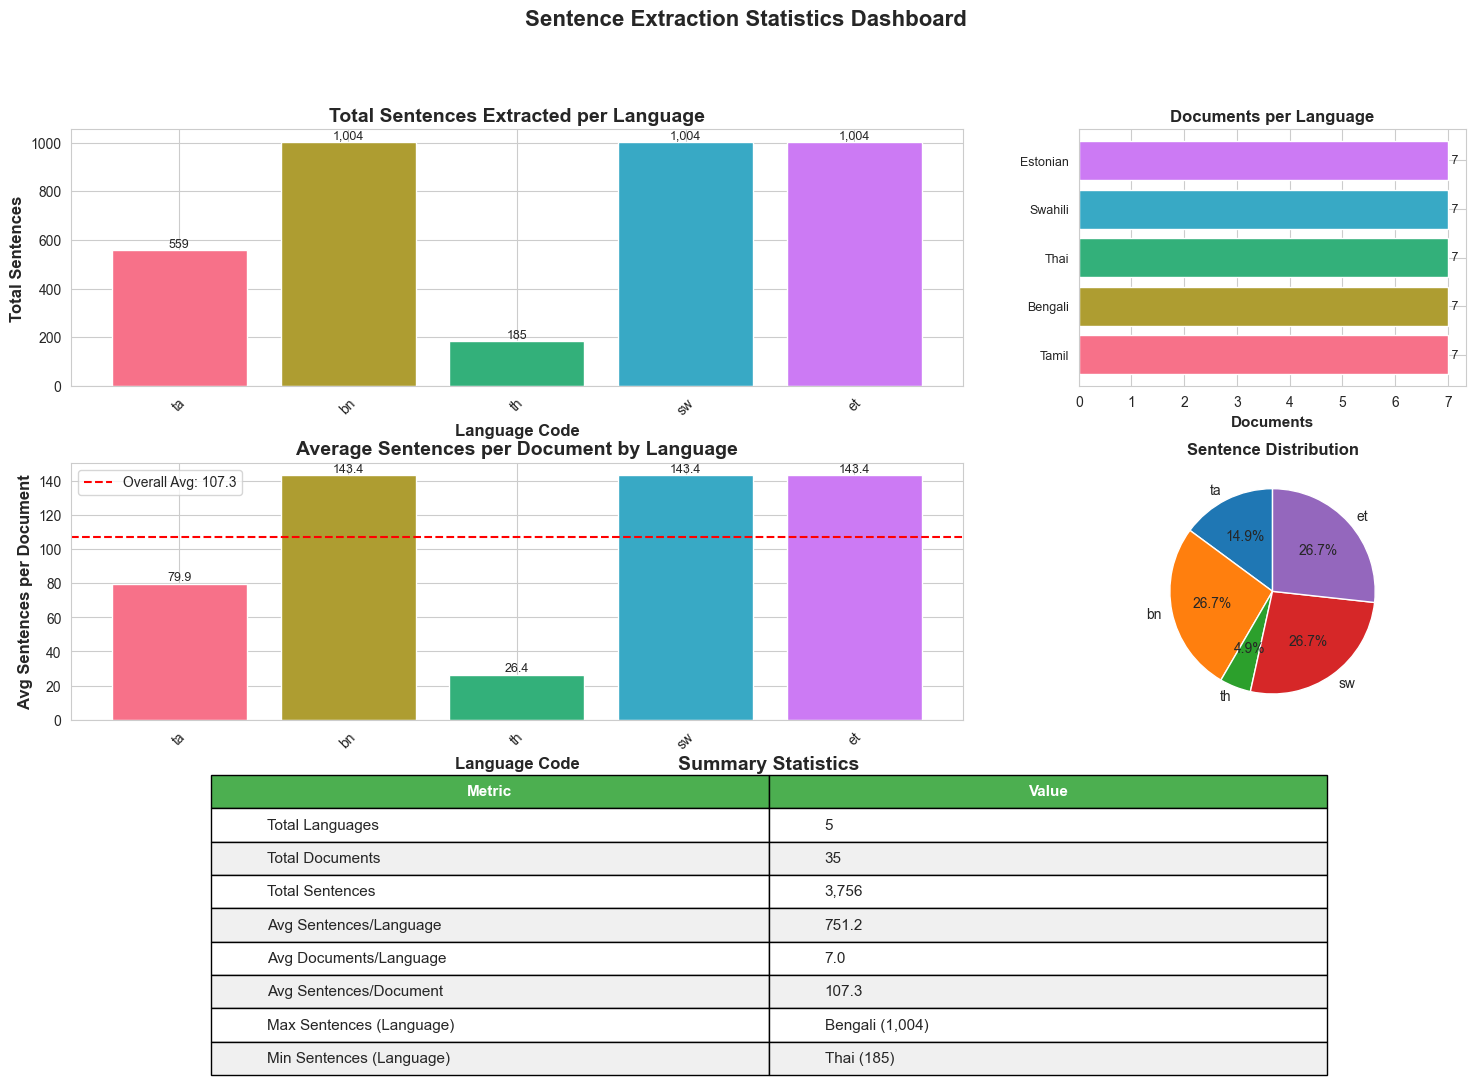


DETAILED LANGUAGE STATISTICS

Language Code  Documents  Sentences  Avg per Doc  % of Total
 Bengali   bn          7       1004        143.4       26.73
Estonian   et          7       1004        143.4       26.73
 Swahili   sw          7       1004        143.4       26.73
   Tamil   ta          7        559         79.9       14.88
    Thai   th          7        185         26.4        4.93

QUARTILE ANALYSIS

Q1 (25th percentile): 559 sentences
Q2 (50th percentile/Median): 1004 sentences
Q3 (75th percentile): 1004 sentences
IQR (Interquartile Range): 445 sentences

LANGUAGE CATEGORIES

High Resource (≥1506 sentences): 0 languages
  

Medium Resource (502-1506 sentences): 4 languages
  ta, bn, sw, et

Low Resource (<502 sentences): 1 languages
  th



In [60]:
# Comprehensive Statistics Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Sentences per Language (Bar Chart)
ax1 = fig.add_subplot(gs[0, :2])
colors = sns.color_palette("husl", len(stats_df))
bars = ax1.bar(stats_df["Code"], stats_df["Sentences"], color=colors)
ax1.set_xlabel("Language Code", fontsize=12, fontweight="bold")
ax1.set_ylabel("Total Sentences", fontsize=12, fontweight="bold")
ax1.set_title("Total Sentences Extracted per Language", fontsize=14, fontweight="bold")
ax1.tick_params(axis="x", rotation=45)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# 2. Documents per Language (Bar Chart)
ax2 = fig.add_subplot(gs[0, 2])
ax2.barh(stats_df["Language"], stats_df["Documents"], color=colors)
ax2.set_xlabel("Documents", fontsize=11, fontweight="bold")
ax2.set_title("Documents per Language", fontsize=12, fontweight="bold")
ax2.tick_params(axis="y", labelsize=9)
for i, v in enumerate(stats_df["Documents"]):
    ax2.text(v, i, f" {v}", va="center", fontsize=9)

# 3. Average Sentences per Document
ax3 = fig.add_subplot(gs[1, :2])
avg_per_doc = stats_df["Sentences"] / stats_df["Documents"]
bars = ax3.bar(stats_df["Code"], avg_per_doc, color=colors)
ax3.set_xlabel("Language Code", fontsize=12, fontweight="bold")
ax3.set_ylabel("Avg Sentences per Document", fontsize=12, fontweight="bold")
ax3.set_title(
    "Average Sentences per Document by Language", fontsize=14, fontweight="bold"
)
ax3.tick_params(axis="x", rotation=45)
ax3.axhline(
    y=avg_per_doc.mean(),
    color="red",
    linestyle="--",
    label=f"Overall Avg: {avg_per_doc.mean():.1f}",
)
ax3.legend()
for bar in bars:
    height = bar.get_height()
    ax3.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# 4. Distribution Pie Chart
ax4 = fig.add_subplot(gs[1, 2])
total_sentences = stats_df["Sentences"].sum()
percentages = stats_df["Sentences"] / total_sentences * 100
# Only show top languages to avoid clutter
top_n = 8
if len(stats_df) > top_n:
    top_langs = stats_df.nlargest(top_n, "Sentences")
    other_sentences = stats_df.nsmallest(len(stats_df) - top_n, "Sentences")[
        "Sentences"
    ].sum()
    pie_data = list(top_langs["Sentences"]) + [other_sentences]
    pie_labels = list(top_langs["Code"]) + ["Others"]
else:
    pie_data = stats_df["Sentences"]
    pie_labels = stats_df["Code"]

ax4.pie(pie_data, labels=pie_labels, autopct="%1.1f%%", startangle=90)
ax4.set_title("Sentence Distribution", fontsize=12, fontweight="bold")

# 5. Summary Statistics Table
ax5 = fig.add_subplot(gs[2, :])
ax5.axis("tight")
ax5.axis("off")

summary_data = [
    ["Total Languages", len(stats_df)],
    ["Total Documents", f"{stats_df['Documents'].sum():,}"],
    ["Total Sentences", f"{stats_df['Sentences'].sum():,}"],
    ["Avg Sentences/Language", f"{stats_df['Sentences'].mean():.1f}"],
    ["Avg Documents/Language", f"{stats_df['Documents'].mean():.1f}"],
    [
        "Avg Sentences/Document",
        f"{(stats_df['Sentences'].sum() / stats_df['Documents'].sum()):.1f}",
    ],
    [
        "Max Sentences (Language)",
        f"{stats_df.loc[stats_df['Sentences'].idxmax(), 'Language']} ({stats_df['Sentences'].max():,})",
    ],
    [
        "Min Sentences (Language)",
        f"{stats_df.loc[stats_df['Sentences'].idxmin(), 'Language']} ({stats_df['Sentences'].min():,})",
    ],
]

table = ax5.table(
    cellText=summary_data,
    colLabels=["Metric", "Value"],
    cellLoc="left",
    loc="center",
    colWidths=[0.4, 0.4],
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)
# Style header
for i in range(2):
    table[(0, i)].set_facecolor("#4CAF50")
    table[(0, i)].set_text_props(weight="bold", color="white")
# Alternate row colors
for i in range(1, len(summary_data) + 1):
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor("#f0f0f0")

ax5.set_title("Summary Statistics", fontsize=14, fontweight="bold", pad=20)

plt.suptitle(
    "Sentence Extraction Statistics Dashboard", fontsize=16, fontweight="bold", y=0.98
)

plt.tight_layout()
plt.show()

# Additional detailed statistics
print("\n" + "=" * 80)
print("DETAILED LANGUAGE STATISTICS")
print("=" * 80 + "\n")

detailed_stats = stats_df.copy()
detailed_stats["Avg per Doc"] = (
    detailed_stats["Sentences"] / detailed_stats["Documents"]
).round(1)
detailed_stats["% of Total"] = (
    detailed_stats["Sentences"] / detailed_stats["Sentences"].sum() * 100
).round(2)
detailed_stats = detailed_stats.sort_values("Sentences", ascending=False)

print(detailed_stats.to_string(index=False))

# Quartile analysis
print("\n" + "=" * 80)
print("QUARTILE ANALYSIS")
print("=" * 80 + "\n")

quartiles = stats_df["Sentences"].quantile([0.25, 0.5, 0.75])
print(f"Q1 (25th percentile): {quartiles[0.25]:.0f} sentences")
print(f"Q2 (50th percentile/Median): {quartiles[0.5]:.0f} sentences")
print(f"Q3 (75th percentile): {quartiles[0.75]:.0f} sentences")
print(f"IQR (Interquartile Range): {(quartiles[0.75] - quartiles[0.25]):.0f} sentences")

# Languages by category
print("\n" + "=" * 80)
print("LANGUAGE CATEGORIES")
print("=" * 80 + "\n")

median_sentences = stats_df["Sentences"].median()
high_resource = stats_df[stats_df["Sentences"] >= median_sentences * 1.5]
medium_resource = stats_df[
    (stats_df["Sentences"] >= median_sentences * 0.5)
    & (stats_df["Sentences"] < median_sentences * 1.5)
]
low_resource = stats_df[stats_df["Sentences"] < median_sentences * 0.5]

print(
    f"High Resource (≥{median_sentences * 1.5:.0f} sentences): {len(high_resource)} languages"
)
print(f"  {', '.join(high_resource['Code'].tolist())}\n")

print(
    f"Medium Resource ({median_sentences * 0.5:.0f}-{median_sentences * 1.5:.0f} sentences): {len(medium_resource)} languages"
)
print(f"  {', '.join(medium_resource['Code'].tolist())}\n")

print(
    f"Low Resource (<{median_sentences * 0.5:.0f} sentences): {len(low_resource)} languages"
)
print(f"  {', '.join(low_resource['Code'].tolist())}\n")